In [563]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA
from scipy.special import comb
from scipy.stats import gaussian_kde, norm
import pandas as pd
from lenstools.statistics.ensemble import Series,Ensemble
from lenstools.statistics.constraints import Emulator
from lenstools.statistics.contours import ContourPlot
from lenstools.statistics.samplers import emcee_sampler
from itertools import cycle
import seaborn as sns
import emcee
from matplotlib.colors import LogNorm
from multiprocessing import Pool
from scipy.stats import skew
from scipy.stats import kurtosis as kurt

In [564]:
def standard_error_skew(n):
    return np.sqrt(6*n*(n-1)/((n-2)*(n+1)*(n+3)))

In [565]:
def standard_error_kurt(n):
    return np.sqrt(24*n*(n-1)**2/((n-3)*(n-2)*(n+3)*(n+5)))

In [566]:
datapath = "../powerspec.csv"
data = pd.read_csv(datapath)
data.pop("Unnamed: 0")
ell_bins = [f"ell{i}" for i in range(37)]

In [567]:
ell = np.logspace(np.log10(500), np.log10(5000),37)
train_data = data[ell_bins].to_numpy()

# _, unique_idx = np.unique(train_data, return_index=True,axis=0)
# train_data = train_data[unique_idx]

# Preprocessing

In [568]:
centered_data = train_data - np.mean(train_data,axis=0)

BIG_cov = np.cov(train_data.T)

L = np.linalg.cholesky(np.linalg.inv(BIG_cov))

prepro_data = centered_data @ L

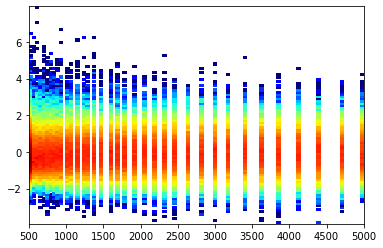

In [569]:
# Prepare data for trained sampled data points
ind = np.random.randint(0,prepro_data.shape[0],5000)
smp_real_data = prepro_data[ind]
ells = smp_real_data.flatten()
ells = np.vstack((ells, np.tile(np.logspace(np.log10(500), np.log10(5000), 37), len(smp_real_data)))).T
l = ells[:, 1]
P = ells[:,0]

plt.figure()
counts,ybins,xbins,image = plt.hist2d(l,P, bins=100, cmap="jet", norm=LogNorm())

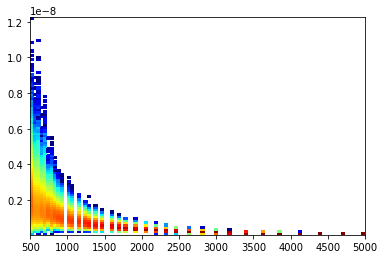

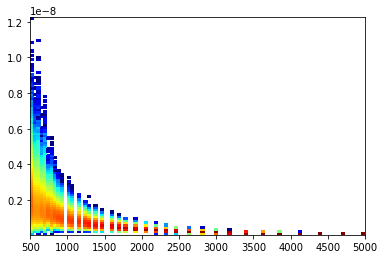

In [570]:
rereversed_data = (prepro_data ) @ np.linalg.inv(L) + np.mean(train_data,axis=0)

# Prepare data for trained sampled data points
smp_real_data = rereversed_data
ells = smp_real_data.flatten()
ells = np.vstack((ells, np.tile(np.logspace(np.log10(500), np.log10(5000), 37), len(smp_real_data)))).T
l = ells[:, 1]
P = ells[:,0]

plt.figure()
counts,ybins,xbins,image = plt.hist2d(l,P, bins=100, cmap="jet", norm=LogNorm())
plt.show()

# plot OG data for comparison
smp_real_data = train_data
ells = smp_real_data.flatten()
ells = np.vstack((ells, np.tile(np.logspace(np.log10(500), np.log10(5000), 37), len(smp_real_data)))).T
l = ells[:, 1]
P = ells[:,0]
plt.figure()
counts,ybins,xbins,image = plt.hist2d(l,P, bins=100, cmap="jet", norm=LogNorm())
plt.show()

# GMM

In [571]:
gmm = GMM(n_components=2)
# Train gmm on log of power spectrum
gmm.fit(prepro_data)

GaussianMixture(n_components=2)

In [572]:
t_skew_real_set = []
t_kurt_real_set = []
t_skew_gmm_set = []
t_kurt_gmm_set = []

n_samples = 2048
np.random.seed(42)

SE_skew = standard_error_skew(n_samples)
SE_kurt = standard_error_kurt(n_samples)

for i in range(100):
    # Randomly sample from training data
    ind = np.random.randint(0,prepro_data.shape[0],n_samples)
    smp_real_data = prepro_data[ind]
    real_skew = skew(smp_real_data,axis=0)
    real_kurt = kurt(smp_real_data,axis=0)
    
    # Gmm was trained on log of data, so scale back to normal with np.exp
    smp_gmm_data = gmm.sample(n_samples=n_samples)[0]
    gmm_skew = skew(smp_gmm_data,axis=0)
    gmm_kurt = kurt(smp_gmm_data,axis=0)
    
    t_skew_real = real_skew/SE_skew
    t_skew_real_set.append(t_skew_real)
    
    t_kurt_real = real_kurt/SE_kurt
    t_kurt_real_set.append(t_kurt_real)
    
    t_skew_gmm = gmm_skew/SE_skew
    t_skew_gmm_set.append(t_skew_gmm)
    
    t_kurt_gmm = gmm_kurt/SE_kurt
    t_kurt_gmm_set.append(t_kurt_gmm)

avg_t_skew_real = np.array(t_skew_real_set).mean(axis=0)
std_t_skew_real = np.array(t_skew_real_set).std(axis=0)

avg_t_kurt_real = np.array(t_kurt_real_set).mean(axis=0)
std_t_kurt_real = np.array(t_kurt_real_set).std(axis=0)

avg_t_skew_gmm = np.array(t_skew_gmm_set).mean(axis=0)
std_t_skew_gmm = np.array(t_skew_gmm_set).std(axis=0)

avg_t_kurt_gmm = np.array(t_kurt_gmm_set).mean(axis=0)
std_t_kurt_gmm = np.array(t_kurt_gmm_set).std(axis=0)

# t-statistics test

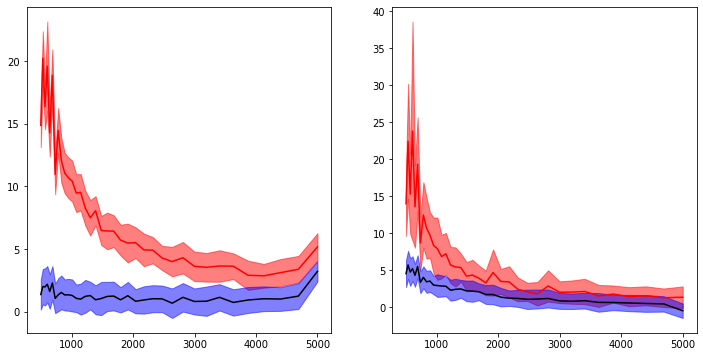

In [573]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(ell,avg_t_skew_real,'r-')
ax[0].fill_between(ell,avg_t_skew_real+std_t_skew_real,avg_t_skew_real-std_t_skew_real,alpha=0.5,color='r')
ax[0].plot(ell,avg_t_skew_gmm,'k-')
ax[0].fill_between(ell,avg_t_skew_gmm+std_t_skew_gmm,avg_t_skew_gmm-std_t_skew_gmm,alpha=0.5,color='b')

ax[1].plot(ell,avg_t_kurt_real,'r-')
ax[1].fill_between(ell,avg_t_kurt_real+std_t_kurt_real,avg_t_kurt_real-std_t_kurt_real,alpha=0.5,color='r')
ax[1].plot(ell,avg_t_kurt_gmm,'k-')
ax[1].fill_between(ell,avg_t_kurt_gmm+std_t_kurt_gmm,avg_t_kurt_gmm-std_t_kurt_gmm,alpha=0.5,color='b')

plt.show()

# GMM power spectrum

In [574]:
# Prepare data for GMM sampled data points
smp_gmm_data = gmm.sample(n_samples=n_samples)[0]
ells = smp_gmm_data.flatten()
ells = np.vstack((ells, np.tile(np.logspace(np.log10(500), np.log10(5000), 37), len(smp_gmm_data)))).T
l = ells[:, 1]
P = ells[:,0]

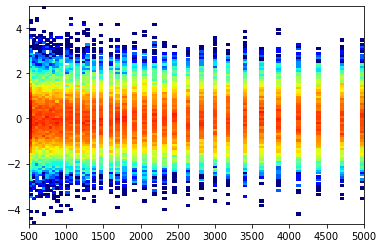

In [575]:
plt.figure()
counts,ybins,xbins,image = plt.hist2d(l,P, bins=100, cmap="jet", norm=LogNorm())

# Mock data power spectrum

In [576]:
# Prepare data for trained sampled data points
ind = np.random.randint(0,train_data.shape[0],n_samples)
smp_real_data = train_data[ind]
ells = smp_real_data.flatten()
ells = np.vstack((ells, np.tile(np.logspace(np.log10(500), np.log10(5000), 37), len(smp_real_data)))).T
l = ells[:, 1]
P = ells[:,0]

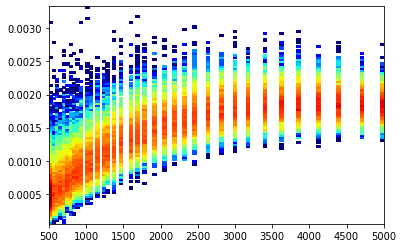

In [577]:
plt.figure()
counts,ybins,xbins,image = plt.hist2d(l,l*(l+1)*P, bins=100, cmap="jet", norm=LogNorm())

## KL Divergence /w MVN

In [578]:
from scipy.stats import multivariate_normal

#mvn = multivariate_normal.pdf(prepro_data,
#                              np.mean(prepro_data,axis=0),
#                              np.cov(prepro_data.T))

mvn_samples = multivariate_normal.rvs(mean=np.mean(prepro_data,axis=0),
                                     cov=np.cov(prepro_data.T),
                                     size=2048)

In [286]:
mvn_samples[:2]

array([[-2.53366177e-01, -1.08601588e+00,  1.53573935e-01,
         2.75239746e+00,  2.80916998e-01, -4.20428546e-01,
         8.95561189e-01,  2.02894112e+00, -1.83984921e-01,
        -1.28553602e+00, -1.99229184e+00, -1.14991265e-01,
        -1.56435215e+00, -1.59958046e+00, -1.90848289e-01,
         6.44916575e-02,  1.18086025e+00,  2.11953762e-01,
        -7.43611365e-01,  2.08867902e+00, -1.75465444e+00,
         2.50454357e-01,  4.71874657e-01, -1.83055711e+00,
        -2.81234864e-02,  4.78227223e-02, -1.57224877e+00,
        -1.01545639e+00, -1.74183705e+00,  4.85239407e-02,
         5.26580501e-01, -4.20095711e-01,  2.37907107e-01,
        -2.16175363e+00, -1.39384031e+00,  1.46293723e-01,
         4.53510737e-01],
       [ 6.32512103e-01,  4.55986051e-01, -9.27505432e-01,
         9.47278599e-01, -1.09932761e+00,  7.36830345e-01,
         2.04501439e+00,  2.25008087e-03,  6.42604974e-01,
        -3.17562818e-01, -6.00432247e-01, -5.62365550e-01,
        -3.42635792e-01,  1.09

In [287]:
gmm_samples = gmm.sample(n_samples=2048)[0]
gmm_samples[:2]

array([[ 0.71111713, -0.34457437, -0.85114738,  0.15106343,  1.53807991,
         1.09969391, -1.5169755 ,  0.7363747 ,  0.96212566,  0.20666401,
         0.26018919,  1.37364804, -1.45081329,  0.41980302,  0.42028886,
         0.69011275, -0.28600333,  0.53676445, -1.17348577, -1.2640201 ,
         0.10999086,  0.54151723, -0.70787614,  2.05883237, -0.87628646,
        -0.41008704,  0.63388419,  1.56144387,  1.52509412, -0.25036392,
         0.78004774, -0.79764259, -2.07821232,  0.32387935,  0.23279313,
        -0.75311506,  1.32418776],
       [ 1.51064255,  0.61488859,  0.68954843,  0.91114088,  1.39798397,
         0.67316741, -0.0279763 ,  0.77666112,  0.61062362,  1.28627513,
         1.29161149,  0.14148787, -1.82472845,  0.60763043,  0.90650966,
         0.22315238,  0.75654148,  2.79987248, -2.10124844,  2.65248781,
         0.64055953,  1.64064369,  0.73722796,  0.31121693, -0.45151836,
        -0.52248749,  3.25589831, -1.57282528, -1.7186209 ,  0.54217662,
        -0.05272

In [288]:
def KL(X, Y, d=37):
    # see eq 23   
    n = X.shape[0]
    m = Y.shape[0]
    
    nu_k = np.zeros(n)
    rho_k = np.zeros(n)
    
    for i in range(n):
        rho_k_dist = np.sum((X - X[i])**2,axis=1)**0.5
        rho_k_dist[rho_k_dist==0] = 999 # lazy cheat
        #bad_idx = rho_k_dist==999
        rho_k[i] = np.min(rho_k_dist)
        
        
        nu_k_dist = np.sum((Y - X[i])**2,axis=1)**0.5
        nu_k[i] = np.min(nu_k_dist)

    return d/n * np.sum(np.log(nu_k/rho_k)) + np.log(m/(n-1))

In [289]:
KL_MVN = []
KL_GMM = []
KL_ref = []

for i in range(25):
    if i%5==0: print(str(i)+'...')
    
    mvn_samples = multivariate_normal.rvs(mean=np.mean(prepro_data,axis=0),
                                     cov=np.cov(prepro_data.T),
                                     size=2048)
    
    mvn2_samples = multivariate_normal.rvs(mean=np.mean(prepro_data,axis=0),
                                 cov=np.cov(prepro_data.T),
                                 size=2048)
    
    gmm_samples = gmm.sample(n_samples=2048)[0]
    
    ind = np.random.randint(0,prepro_data.shape[0],2048)
    mock_samples = prepro_data[ind]
    
    KL_GMM.append(KL(mock_samples,gmm_samples))
    KL_MVN.append(KL(mock_samples,mvn_samples))
    KL_ref.append(KL(mvn_samples,mvn2_samples))

0...


KeyboardInterrupt: 

In [ ]:
n3, bins2, patches3 = plt.hist(KL_ref, 10, density=True, facecolor='k', alpha=0.75,label='MVM|MVN')
n, bins, patches = plt.hist(KL_GMM, 10, density=True, facecolor='g', alpha=0.75,label='mock|GMM')
n2, bins2, patches3 = plt.hist(KL_MVN, 10, density=True, facecolor='r', alpha=0.75,label='mock|MVN')


plt.xlabel('KL')
plt.legend()
plt.show()
plt.tight_layout()

# Pairwise

In [560]:
def zca_whiten(X):
    cov = np.cov(X.T)
    U, Sigma, Vt = np.linalg.svd(cov)
    D = np.diag(np.sqrt(1/(Sigma)))
    W = U @ D @ Vt
    centered = X - X.mean(axis=0)
    whitened = np.einsum("...j, ij -> ...i", centered, W)
    return whitened

def pca_whiten(X):
    cov = np.cov(X.T)
    Sigma, U = np.linalg.eig(cov)
    D = np.diag(np.sqrt(1/(Sigma)))
    W = D @ U.T
    centered = X - X.mean(axis=0)
    whitened = np.einsum("...j, ij -> ...i", centered, W)
    return whitened

def gaussian_pdf(x, mean, var):
    return 1/np.sqrt(2 * np.pi * var) * np.exp(-0.5 * (x - mean)**2/var)

def pairwise(X, bins=10):
    """
    Pairs bins as described in III.B for a single power spectra
    
    bins: The number of point at which to evaluate the kde and N(0, 2) -> large number of bins is a bottleneck of this code
    """  
    d = X.shape[1]
    
    _X = X.copy()
    
    x = np.linspace(-4, 4, bins) # point where we evaluate the the KDE
    
    total = int(comb(d, 2)) # comb is the bin

    # get paired bins (eq 18)
    H_b = []
    ell = 0
    for i in range(d):
        for j in range(i+1, d):
            
            pairs = zca_whiten(_X[:, (i, j)])
                        
            # fit a kde on the sum
            s = pairs[:, 0] + pairs[:, 1]
            K = gaussian_kde(s) # scott bandwidth by default
            
            # get the pdf value at given points
            s = K.pdf(x)
            H_b.append(s)
            
            print(f"\r pairs done: {ell}/{int(total-1):d}", end="", flush=True)
            ell += 1
    H_b = np.array(H_b)    
    return H_b.T, x


def transcovariance_score(X):
    d = X.shape[1]
    
    Hb, x = pairwise(X)
    
    X = np.tile(x, (Hb.shape[1], 1)).T
    
    # mean integrated square error
    mise = ((Hb - gaussian_pdf(X, mean=0, var=2))**2).mean(axis=0)
    
    # fill upper and lower triangle of the power spectrum bin matrix
    mise_mat = np.zeros((d, d))
    upper_tri = np.triu_indices(d, k=1) # k=1: omit diagonal
    
    mise_mat[upper_tri] = mise
    mise_mat.T[upper_tri] = mise # fill the lower triangle
    
    epsilon_plus = mise_mat.sum(axis=1)  # sum over any axes

    return epsilon_plus

In [561]:
eps = transcovariance_score(train_data)

 pairs done: 665/665

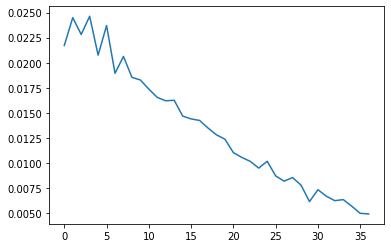

In [562]:
plt.plot(eps)

 pairwise status: 665/665

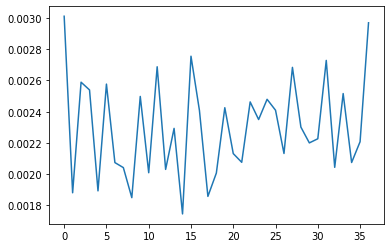

In [557]:
X = np.random.normal(size=(1000, 37))
eps = transcovariance_score(X)
plt.plot(eps)